# Probability


In [1]:
### PREAMBLE
# Basics of probability
# probability.svg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pprint
import itertools
import scipy.misc as misc

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

Up until this point in the course, we have largely ignored formal probabilistic statements or formal definitions of probability.  This may seem somewhat surprising: the topic of probability is naturally tightly intertwined with data science and machine learning, and it may seem odd to have gotten so deep into these topics (it is also not quite true, since we did use probability in an informal way when discussion n-gram models for free text).  But we previously largedly considered machine learning from an optimization context, in terms of minimizing loss function, and even our presentation of generalization and overfitting only mentioned probability informally.

From this point on, this will no longer be the case.  While it is useful to understand machine learning from the optimization standpoint, machine learning as a field is also deep tied to probability and statistics, and the goal of these notes is to provide a basic introduction to some of the principles behind probability.  As a concrete example of why understanding and modeling probabilities can be so important in data science (this is of course just one example), let's return to considering previous example of high temperature vs. peak demand.

Text(0, 0.5, 'Peak Demand')

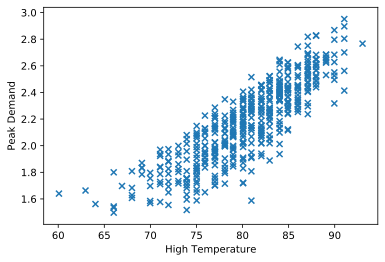

In [3]:
df = pd.read_csv("temp_demand.csv").set_index("Date")
df_summer = df[list(map(lambda x : str(x)[4:6] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("High Temperature")
plt.ylabel("Peak Demand")

Although there _is_ a clear linear pattern to this data, there is also the sense in which we _don't_ expect to be able to predict the peak demand exactly.  After all, peak electrical demand is something that _I_ even have some control over (I could choose to turn a lightswitch on or off tomorrow, which would affect the peak demand, albeit in a very limited manner).  So while we can reduce the uncertainty somewhat (remember, for example, that including a "weekday" versus "weekend" feature did exactly this), we don't expect to eliminate the uncertainty completely, at least not at the level that we are ever going to be able to observe the data.  This is a critical point: _many machine learning tasks cannot be "solved" in the sense of getting perfect predictions, but the correct solution is instead just to accurately quantify the distribution over possible outputs_.

With this in mind, we're going to begin our discussion on basic probability, with the next section additionally covering some basic statistics.  This distinction is actually quite important, and for the purposes of this course you can think of it as the following: probability covers the basic rules of random variables manipulating expressions related to them, while statistics involves the incorporation of data (i.e., fitting probability distributions to observations).  These notes will be covering the former category, understanding the rules behind random variables and how we make statements about them.

## Random Variables

The basic building block of probability is the random variable.  If you take a more formal course in probability theory, you will see a much more rigorous definition of a random variable (i.e., random variables as functions), and even some introductory courses describe them from a more formal standpoint (talking about outcome spaces, the axioms of probability, etc).  In this course (because this is just a single lecture, after all), we're going to eschew all this formality, and present random variables at the level that I believe to be intuitive and useful for data science.  In particular, the main thing you'll do with probabilities in data science tasks is use some basic properties of probability to manipulate probabilistic expressions, and describe random variables using some basic well-known distributions.  We'll talk about both these elements here.

For our purposes, you can think of a random variable as just a variable "whose value is not yet known".  Rather, each value that the variable may take on has some probability of occuring (yes, this is a circular definition, but we're presuming you have an intuitive notion of probability at this level).  For example, "Weather" could be a random variable representing the weather that will occur tomorrow, which can take values in {"sunny", "rainy", "cloudy", "snowy"), each with some associated probability
\begin{equation}
\begin{split}
p(\mbox{Weather} = \mbox{sunny}) & = 0.3\\
p(\mbox{Weather} = \mbox{rainy}) & = 0.2\\
\vdots
\end{split}
\end{equation}

We'll need a slightly different notation for continuous random variable, which we'll discuss later.

### Notation for random variables

One of the hardest parts about understanding what is meant by certain notation.  And we fully admit that the notation for probability _is_ often quite confusing, and seems somewhat odd at first.  But underlying this are some fairly simple rules, which we will stick to at least for this set of notes.  The potentially annoying aspect is that this notation can and does change when we shift back to talk about machine learning, for example (and we will also change the notation back to be what is common in those areas), but hopefully at that point you'll have a sufficient understanding of the topic to understand what is meant in different situations.

In general, we will use captial letters, $X$ to represent random variables.  Or if the random variable is a quantity like weather, we will use the capitalized $\mbox{Weather}$ to denote the random variable.  For a random variable $X$ taking on values, say in $\{1,2,3\}$, the notation
\begin{equation}
p(X)
\end{equation}
represent the _entire probability distribution_ of the random variable $X$.  In other words, you should think of $p(X)$ really as representing a function mapping from the different values that $X$ can take on to their associated probabilities.  In Python, you could implement this as a dictionary for instance.

In [4]:
pX = {1: 0.1, 2: 0.5, 3:0.4}
pWeather = {"sunny": 0.3, "rainy":0.2, "cloudy":0.4, "snowy":0.1}

This notation $p(X)$ is somewhat unfortunate, because $p(X)$ does not really represented a function _of_ $X$, but an entire function mapping values that $X$ takes on to positive numbers (which need to sum to one).  Yet we also won't use notation like $p(X)(1)$ either, but instead using something like $p(X=1)$, so this seems a bit ambiguous.  A better notation would be something like $p_X$, but this is less common, so we'll stick to the usual $p(X)$, as long as you understand that this really refers to the entire distribution.

If we _do_ want to refer to a specific value that $X$ takes on, we'll use the lowercase $x$, i.e., in the above case to represent one of the values that $X$ takes on, $x \in \{1,2,3\}$.  When then use the notation
\begin{equation}
p(X=x) \;\; \mbox{or just} \;\; p(x)
\end{equation}
to represent the probability (i.e., the numerical value) of that particular probability.  Again in code, this would look something like the following.

In [5]:
pX[1]
pWeather["sunny"]

0.3

### Joint distributions and factors

Given two random variables $X_1$ (taking values in $\{1,2,3\}$) and $X_2$ (taking values in $\{1,2\}$), their _joint distribution_, written $p(X_1,X_2)$ is a probability distribution mapping all possible values that both variables can take on to the respective probability.  For example, again in Python:

In [6]:
pX1X2 = {(1,1): 0.3, (1,2):0.1, (2,1):0.05, (2,2): 0.25, (3,1):0.15, (3,2):0.15}
print(pX1X2)

{(1, 1): 0.3, (1, 2): 0.1, (2, 1): 0.05, (2, 2): 0.25, (3, 1): 0.15, (3, 2): 0.15}


Then as above, $p(x_1, x_2)$ would represent a _number_ corresponding to a single entry in this distribution (the probability that $X_1 = x_1$ and $X_2 = x_2$).

In [7]:
pX1X2[(1,2)]

0.1

Where this gets a bit tricky in when we _combine_ both types of expressions.  For example $p(X_1,x_2)$ would correspond to the entries in the above probability take for _all_ values of $X_2$, but only for a particular value of $X_2$.  In other words, it would be a function mapping from values in $X_1$ to real numbers.  In Python, this would essentially reduce to creating a new dictionary over all values of $X_1$, for a particular assignment to $x_2$.  Importantly, however, $p(X_1, x_2)$ is _not_ a true probability distribution over $X_1$, because the values do not sum to one.  Instead, these terms are generally referred to as _factors_, which you can think of like probability distributions (mappings from variables assignments to values), except that their entries need not sum to one.

In [8]:
fX1 = {k[0]:v for k,v in pX1X2.items() if k[1] == 2}
fX1

{1: 0.1, 2: 0.25, 3: 0.15}

As a more concrete example, let's consider two random variables: $\mbox{Weather}$ (the weather tomorrow, for now taking values in $\{\mbox{sunny}, \mbox{rainy}, \mbox{cloudy}\}$ ) and $\mbox{Cavity}$ (whether or not I have a cavity, taking values in $\{\mbox{yes}, \mbox{no}$); there are some old adages about people being able to predict the weather from pain in their teeth, so maybe there is some relation between these variables.  Let's first look at the complete joint distribution:
\begin{equation}
p(\mbox{Weather}, \mbox{Cavity}) = \left \{ 
\begin{array}{llr}
\mbox{sunny} & \mbox{yes} & 0.07 \\
\mbox{sunny} & \mbox{no} & 0.63 \\
\mbox{rainy} & \mbox{yes} & 0.02 \\
\mbox{rainy} & \mbox{no} & 0.18 \\
\mbox{cloudy} & \mbox{yes} & 0.01 \\
\mbox{cloudy} & \mbox{no} & 0.09
\end{array} \right .
\end{equation}

If we want to refer to a single entry, we just have
\begin{equation}
p(\mbox{Weather} = \mbox{sunny}, \mbox{Cavity} = \mbox{yes}) = 0.07.
\end{equation}

Or if we want to look at a partial factor
\begin{equation}
p(\mbox{Weather}, \mbox{Cavity} = \mbox{yes}) = \left \{ 
\begin{array}{lr}
\mbox{sunny} & 0.07 \\
\mbox{rainy} & 0.02 \\
\mbox{cloudy} & 0.01 \\
\end{array} \right .
\end{equation}

Again as Python code:

In [9]:
pWeatherCavity = {("sunny", "yes"):0.07,
                  ("sunny", "no"):0.63,
                  ("rainy", "yes"):0.02,
                  ("rainy", "no"):0.18,
                  ("cloudy", "yes"):0.01,
                  ("cloudy", "no"):0.09}
pprint.pprint(pWeatherCavity)
print(pWeatherCavity[("sunny", "yes")])
fWeather = {k[0]:v for k,v in pWeatherCavity.items() if k[1] == "yes"}
pprint.pprint(fWeather)

{('cloudy', 'no'): 0.09,
 ('cloudy', 'yes'): 0.01,
 ('rainy', 'no'): 0.18,
 ('rainy', 'yes'): 0.02,
 ('sunny', 'no'): 0.63,
 ('sunny', 'yes'): 0.07}
0.07
{'cloudy': 0.01, 'rainy': 0.02, 'sunny': 0.07}


### Probability/factor operations

The last topic to discuss if we we perform operations on probabilities/factors.  That is, for instance if $X_1$, $X_2$, and $X_3$ are all random variables (for simplicity say they are all binary, so taking values in $\{0,1\}$), then what does the following operation signify
\begin{equation}
p(X_1,X_2)p(X_2,X_3)?
\end{equation}

The above product would actually be a _new_ factor over all the variables involved in term (that is, a factor over $X_1,X_2,X_3$) whose values are found by just substituting the values into each expression.  Calling this factor $f$ (we typically won't name factors, because we don't need to write them explicitly, and we just do it here to signify the notation)
\begin{equation}
f(X_1 = x_1, X_2 = x_2, X_3 = x_3) = p(X_1 = x_1, X_2 = x_2)p(X_2 = x_2,X_3 = x_3)
\end{equation}

This seems confusing initially, but it is actually probably what you had in mind intuitively anyway.  Put another way, $p(X_1,X_2)p(X_2,X_3)$ is a factor where for any set of values $x_1,x_2,x_3$, to compute the value $p(x_1,x_2)p(x_2,x_3)$; and if you want to compute the full underlying factor (the value for all possible assignments of the variables), you just compute this term for all possible assignments to $x_1, x_2, x_3$.

The following code shows how to compute a factor product like this in Python.  We use the `itertools.product` call to iterate over all combinations of terms in the factors, multiply together the probability values, but then filter out only those elements where the second key of the first product ($x_2$ in the first probability) equals the first key of the second product ($x_2$ in the second probability).

In [10]:
pX1X2 = {(0,0):0.1, (0,1):0.2, (1,0):0.3, (1,1):0.4}
pX2X3 = {(0,0):0.2, (0,1):0.3, (1,0):0.3, (1,1):0.2}

f = {(k1[0], k1[1], k2[1]):v1*v2
     for (k1,v1),(k2,v2) in itertools.product(pX1X2.items(),pX2X3.items())
     if k1[1] == k2[0]}
pprint.pprint(f)

{(0, 0, 0): 0.020000000000000004,
 (0, 0, 1): 0.03,
 (0, 1, 0): 0.06,
 (0, 1, 1): 0.04000000000000001,
 (1, 0, 0): 0.06,
 (1, 0, 1): 0.09,
 (1, 1, 0): 0.12,
 (1, 1, 1): 0.08000000000000002}


### (Aside) A generic Python implementation

The above notation (directly representing probability distributions as dictionaries), gets somewhat cumbersome.  When we wanted to multiply two distributions, we needed to manually remember which variable corresponded to which key in each factor.  Fortunately, we can pretty easily build a class that automates all of this, explicitly storing both the variables and their values as a complete Python dictionary.  Note that without some very heavy optimization, I would not recommend using this class directly, because it always represents factors explicitly in terms of all of their full joint distribution, but as an illustrative tool, it can be useful.

In [11]:
import operator

class Factor:
    def __init__(self, *args):
        self.factors = {(k if isinstance(k, tuple) else (k,)):v for k,v in args[-1].items()}
        self.variables = {var:tuple(set(k[i] for k in self.factors.keys())) for i,var in enumerate(args[:-1])}
    
    def __call__(self, **kwargs):
        if all(var in kwargs for var in self.variables):
            return self.factors[tuple(kwargs[var] for var in self.variables)]
        else:
            new_vars = {k:v for k,v in self.variables.items() if k not in kwargs}
            vals = (dict(zip(new_vars,v)) for v in list(itertools.product(*new_vars.values())))
            return Factor(*new_vars.keys(), {tuple(k.values()):self(**dict(k, **kwargs)) for k in vals})
    
    def op(self, op, f):
        if isinstance(f, Factor):
            new_vars = dict(self.variables, **f.variables)
            vals = (dict(zip(new_vars,v)) for v in list(itertools.product(*new_vars.values())))
            return Factor(*new_vars.keys(), {tuple(k.values()):op(self(**k),f(**k)) for k in vals})
        else:
            return Factor(*self.variables.keys(), {k:op(v,f) for k,v in self.factors.items()})
    
    def __str__(self):
        string = "Factor(" + ", ".join(self.variables.keys()) + ") = {\n"
        for k,v in self.factors.items():
            string += "  " 
            string += ", ".join(["{} = {}".format(var, k[i]) for i,var in enumerate(self.variables)]) 
            string += ": {}\n".format(v)
        string += "}"
        return string

    def __repr__(self):
        return self.__str__()
    
    def __mul__(self, other): return self.op(operator.mul, other)
    def __truediv__(self, other): return self.op(operator.truediv, other)
    def __add__(self, other): return self.op(operator.add, other)
    def __sub__(self, other): return self.op(operator.sub, other)
    def __radd__(self, other): return self.op(operator.add, other)

    

You're welcome to go through the code in detail (there isn't much of it), but it's also a bit dense and it isn't important that you understand the detail here so much as you understand how to use it.  

Let's use this code to set up the example we saw previously.

In [12]:
pWeatherCavity = Factor("Weather", "Cavity", {("sunny", "yes"):0.07,
                                              ("sunny", "no"):0.63,
                                              ("rainy", "yes"):0.02,
                                              ("rainy", "no"):0.18,
                                              ("cloudy", "yes"):0.01,
                                              ("cloudy", "no"):0.09})
print(pWeatherCavity)

Factor(Weather, Cavity) = {
  Weather = sunny, Cavity = yes: 0.07
  Weather = sunny, Cavity = no: 0.63
  Weather = rainy, Cavity = yes: 0.02
  Weather = rainy, Cavity = no: 0.18
  Weather = cloudy, Cavity = yes: 0.01
  Weather = cloudy, Cavity = no: 0.09
}


The `p.variables` attribute is a dictionary that maps variables to all their possible values.

In [13]:
print(pWeatherCavity.variables)

{'Weather': ('rainy', 'cloudy', 'sunny'), 'Cavity': ('yes', 'no')}


And the `p.factors` is the actual dictionary of factors, that we entered above.

In [14]:
pprint.pprint(pWeatherCavity.factors)

{('cloudy', 'no'): 0.09,
 ('cloudy', 'yes'): 0.01,
 ('rainy', 'no'): 0.18,
 ('rainy', 'yes'): 0.02,
 ('sunny', 'no'): 0.63,
 ('sunny', 'yes'): 0.07}


We can specify variable settings by calling the factor with keyword argument.  If we specify all the variables, then we return the number in the factor.

In [15]:
pWeatherCavity(Weather="rainy", Cavity="yes")

0.02

If we specify only some of the variables, then we return a factor over the remaining variables.

In [16]:
pWeatherCavity(Cavity="yes")

Factor(Weather) = {
  Weather = rainy: 0.02
  Weather = cloudy: 0.01
  Weather = sunny: 0.07
}

Finally, we can perform factor operations like multiplication just by multiplying the associated factors.

In [17]:
pCavityDentist = Factor("Cavity", "Dentist", {("yes", "yes"):0.099, 
                                              ("yes","no"):0.001, 
                                              ("no","yes"):0.8, 
                                              ("no","no"):0.1})
print(pCavityDentist)
print(pWeatherCavity*pCavityDentist)

Factor(Cavity, Dentist) = {
  Cavity = yes, Dentist = yes: 0.099
  Cavity = yes, Dentist = no: 0.001
  Cavity = no, Dentist = yes: 0.8
  Cavity = no, Dentist = no: 0.1
}
Factor(Weather, Cavity, Dentist) = {
  Weather = rainy, Cavity = yes, Dentist = yes: 0.00198
  Weather = rainy, Cavity = yes, Dentist = no: 2e-05
  Weather = rainy, Cavity = no, Dentist = yes: 0.144
  Weather = rainy, Cavity = no, Dentist = no: 0.018
  Weather = cloudy, Cavity = yes, Dentist = yes: 0.00099
  Weather = cloudy, Cavity = yes, Dentist = no: 1e-05
  Weather = cloudy, Cavity = no, Dentist = yes: 0.072
  Weather = cloudy, Cavity = no, Dentist = no: 0.009
  Weather = sunny, Cavity = yes, Dentist = yes: 0.006930000000000001
  Weather = sunny, Cavity = yes, Dentist = no: 7.000000000000001e-05
  Weather = sunny, Cavity = no, Dentist = yes: 0.504
  Weather = sunny, Cavity = no, Dentist = no: 0.063
}


We'll use this code to illustrate some of the basic concepts in probability, and hopefully it makes some of the formula more concrete in practice.  However, if it ultimately adds more confusion than it helps, then don't worry about how to use this, and instead just focus on the underlying concepts.

## Basics properties of probability

Rather than try to explain probability from first principles (which is not that difficult, but which is not necessarily that useful in pracie), these notes will focus on the typical defintions/operations that are most useful in actually manipulating probabilities.

### Marginalization

For random variables $X_1$, $X_2$ with joint distribution $p(X_1,X_2)$, we can obtain the distribution over one of these random variables, $p(X_1)$ or $p(X_2)$, sometimes called the _marginal distribution_, by summing over the remaining variable.
\begin{equation}
p(X_1) = \sum_{x_2} p(X_1,x_2)
\end{equation}
Note that the notation $\sum_{x_2}$ (with lower case $x_2$ here means that we sum over all the actual values that the random variable $X_2$ takes on).

We can generalize this to the joint distribution over many variables $p(X_1, \ldots, X_n)$.
\begin{equation}
p(X_1, \ldots, X_i) = \sum_{x_{i+1}, \ldots, x_n} P(X_1,\ldots,X_i, x_{i+1}, \ldots, x_n)
\end{equation}

Finally, in order to be a proper probaiblity (instead of just an arbitrary factor), the sum over all the variables must equal one.
\begin{equation}
\sum_{x_{1}, \ldots, x_n} P(x_1, \ldots, x_n) = 1.
\end{equation}

Let's see how this works with our Factor class.  If we wanted to computer $p(\mathrm{Cavity})$ from our first factor (question to think about: does this have to be the same as for the second factor? what happens if these two probabilities are different?), we can sum over all values of the $\mathrm{Weather}$ variables.

In [18]:
pCavity = pWeatherCavity(Weather = "sunny") + p(Weather="cloudy") + p(Weather="rainy")
print(pCavity)

NameError: name 'p' is not defined

More generally, we can easily definite a `marginalize` function that sums over some of the variables in a factor.

In [20]:
def marginalize(p, *variables):
    vals = [dict(zip(variables, a)) for a in itertools.product(*[p.variables[v] for v in variables])]
    return sum(p(**k) for k in vals)
    
print(marginalize(pWeatherCavity, "Weather"))
print(marginalize(pWeatherCavity, "Cavity"))
print(marginalize(pWeatherCavity, "Weather", "Cavity"))

Factor(Cavity) = {
  Cavity = yes: 0.1
  Cavity = no: 0.9
}
Factor(Weather) = {
  Weather = rainy: 0.19999999999999998
  Weather = cloudy: 0.09999999999999999
  Weather = sunny: 0.7
}
1.0


### Conditional probability

Given two random variables $X_1,X_2$, the _conditional_ probability of $X_1$ given $X_2$ is defined as
\begin{equation}
p(X_1 \mid X_2) = \frac{p(X_1,X_2)}{p(X_2)}.
\end{equation}
This can also be rearranged to give a definition of the joint distribution in terms of the conditional distribution.
\begin{equation}
p(X_1,X_2) = p(X_1 \mid X_2) p(X_2)
\end{equation}
or written in terms of the opposite order
\begin{equation}
p(X_1,X_2) = p(X_2 \mid X_1) p(X_1), 
\end{equation}
(we will shortly use this equivalence to derive Bayes' rule).  By applying this property repeatedly, we can also derive a characterization of the joint distribution for any number of random variables $X_1,\ldots,X_n$, referred to as the _chain rule_
\begin{equation}
p(X_1,\ldots,X_n) = \prod_{i=1}^n p(X_i \mid X_1,\ldots,X_{i-1})
\end{equation}

This charaterization also gives another way of writing the marginalization formula, which can be useful in some situations
\begin{equation}
p(X_1) = \sum_{x_2} p(X_1 \mid x_2) p(x_2).
\end{equation}

Let's again see how this works with our class.  If we want to use this method to compute the probability of "Dentist" (presumably a random variable indicating whether we go to the dentist), we can use the following formula.

In [21]:
pCavity = marginalize(pCavityDentist, "Dentist")
pDentistGivenCavity = pCavityDentist/pCavity
print(pDentistGivenCavity)

Factor(Cavity, Dentist) = {
  Cavity = yes, Dentist = yes: 0.99
  Cavity = yes, Dentist = no: 0.01
  Cavity = no, Dentist = yes: 0.888888888888889
  Cavity = no, Dentist = no: 0.11111111111111112
}


In other words, the probabilty of going to the dentist given that you have a cavity is 0.9, and the probability of going to the dentist if you don't have a cavity is 8/9.  It's important to note here that `pDentistGivenCavity` here is represented as as factor, but it is _not_ a joint probability distribution.  To get a distribution, you need to condition on one of the actual settings of the variables we are conditioning on (i.e., in this case, the "Cavity") variable.  So for example, the following would of course be a distribution.

In [22]:
pDentistGivenCavity(Cavity="yes")

Factor(Dentist) = {
  Dentist = yes: 0.99
  Dentist = no: 0.01
}

## Bayes' rule

Bayes' rule has a special place in probability and machine learning, but fundamentally it is just a simple application of the two rules of probability described above  Fundamentally, it provides a way to express the conditional distribution $p(X_1 \mid X_2)$ in terms of the opposite conditional $p(X_2 \mid X_1)$ and the marginal probability (in this context, often called the _prior probability_) $p(X_1)$.  Specifically, Bayes' rule is given by
\begin{equation}
p(X_1 \mid X_2) = \frac{p(X_2 \mid X_1)p(X_1)}{\sum_{x_1} p(X_2 \mid x_1)p(x_1)}
\end{equation}
which just follows trivially from the above definitions of conditional probability and marginalization
\begin{equation}
p(X_1 \mid X_2) = \frac{p(X_1,X_2)}{p(X_2)} = \frac{p(X_2 \mid X_1)p(X_1)}{\sum_{x_1} p(X_2 \mid x_1)p(x_1)}.
\end{equation}

The rule is particularly useful when probability are given in terms of the quantities on the right hand side, but _not_ the left hand side.  A very common example is something like the following:

> I want to know if I have come with with a rate strain of flu (occurring in only 1/10,000 people).  There is an “accurate” test for the flu (if I have the flu, it will tell me I have 99% of the time, and if I do not have it, it will tell me I do not have it 99% of the time).  I go to the doctor and test positive.  What is the probability I have the this flu?

Most people (and quite unsettlingly, apparently [most doctors](http://www.bbc.com/news/magazine-28166019)) tend to see this and guess that the probability of having the flu would be high here, probably approximately the 99% accuracy of the test.  But this is not the case.  To see this, let's specify the terms here in terms of random variables.  Let $\mathrm{Flu}$ be the random variable associated with whether I have the flu, and let $\mathrm{Test}$ be the random variable associated with whether I test positive (both are binary variables).  What we would like to know is the quantity
\begin{equation}
p(\mathrm{Flu} = 1 \mid \mathrm{Test} = 1).
\end{equation}
But we aren't given this quantity directly.  Reading off the probabilities from the text example, we instead know that
\begin{equation}
\begin{split}
p(\mathrm{Flu} = 1) & = 0.0001 \\
p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 1) & = 0.99 \\
p(\mathrm{Test} = 0 \mid \mathrm{Flu} = 0) & = 0.99
\end{split}
\end{equation}
and since the probabilities are all binary here, this also implies that
\begin{equation}
\begin{split}
p(\mathrm{Flu} = 0) & = 1 - p(\mathrm{Flu} = 1) = 0.9999 \\
p(\mathrm{Test} = 0 \mid \mathrm{Flu} = 1) & = 1 - p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 1) = 0.01 \\
p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 0) & = 1 - p(\mathrm{Test} = 0 \mid \mathrm{Flu} = 0) = 0.01.
\end{split}
\end{equation}

Now let's apply Bayes' rule to compute the term $p(\mathrm{Flu} = \mathrm{true} \mid \mathrm{Test} = \mathrm{positive})$.  We know that
\begin{equation}
\begin{split}
p(\mathrm{Flu} = 1 \mid \mathrm{Test} = 1) & = 
\frac{p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 1) p(\mathrm{Flu} = 1)}
{p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 1) p(\mathrm{Flu} = 1) + p(\mathrm{Test} = 1 \mid \mathrm{Flu} = 0) p(\mathrm{Flu} = 0)} \\
& = \frac{0.99 \cdot 0.0001}{0.99 \cdot 0.0001 + 0.01 \cdot 0.9999} \approx 0.0098
\end{split}
\end{equation}


So I actually have less than a 1% chance of having the flu.  What is happening here?  The "intuitive" explanation here is that even though the test is "accurate", because the prior probability of having the flu is so small, chances are that if I test positive, I'm actually one of the false positives, not an actual case of the flu.  For example, imagine there are 10000 total people (so say that one actually has the flu, and suppose just treat "expectations" loosely, that this person even tests positive).  So one person who tests positive does have the flu.  But of the remaining 9999 people, about 100 of them will _also_ test positive for the flu, because there is a 1% chance of this happening to any given person.  So the chances that you are in this false positive group is much higher than being the one person who actually has the flu.

Incidentally, this is why it's generally a bad idea to test _everyone_ for extremely rare dieseases (assuming the tests have any false positives, which is usually the case), unless there is good symptomatic evidence to suspect you have have the disease (not that if we only test people who are sympomatic of the flu mentioned above, this would be a much smaller population, so a much higher prior probability of the flu, and the resulting probabilities would look very different).  It's also worth considering the relative costs of a false positive (probably more detailed test, or unnecessary treatment) balanced with the cost of failing to diagnose the diesease.  These tradeoffs are clearly very important in medicine, which is why it's always particularly jarring to see articles like the above where doctors make these simple mistakes (though in fairness, I wouldn't necesarily put _too_ much weight on simple surveys like that mentioned in the above article:  often the real context under which doctors make these decions, for instance running a test only if the person is actually symptomatic, violates the precise phrasing of the question, but may have been what the doctors had in mind).

Let's finally see how we can write this rule using our Factor class (which incidentally will also give us all the other probabilities associated with our events, such as the probaiblity that you have the flue given that you test negative).

In [23]:
pFlu = Factor("Flu", {0:0.9999, 1:0.0001})
pTestGivenFlu = Factor("Test", "Flu", {(0,0): 0.99, (0,1):0.01, (1,0):0.01, (1,1):0.99})

pFluGivenTest = (pTestGivenFlu * pFlu) / marginalize(pTestGivenFlu * pFlu, "Flu")
print(pFluGivenTest)

Factor(Test, Flu) = {
  Test = 0, Flu = 0: 0.9999989897989902
  Test = 0, Flu = 1: 1.0102010097969295e-06
  Test = 1, Flu = 0: 0.9901960784313726
  Test = 1, Flu = 1: 0.00980392156862745
}


So we see our same conditional probability of less than a 1% chance we have the flu given that we test positive.  But although this is small, it is at least substantially higher than the probability we have the flu given that we test negative.

### Independence

The next topic we'll discuss here, which will be even more important later in the course when we discuss probabilistic models, is the notion of independence.

**Marginal independence** Two variables $X_1$ and $X_2$ are marginally independent (often also just called independent) if their joint distribution is the product of their marginal distributions
\begin{equation}
p(X_1,X_2) = p(X_1)p(X_2)
\end{equation}
An equivalent condition, which can easily be derived from the above, is that two variables are independent if
\begin{equation}
p(X_1 \mid X_2) = p(X_1)
\end{equation}
To see the equivalence here note that
\begin{equation}
p(X_1 \mid X_2) = \frac{p(X_1,X_2)}{p(X_2)} = \frac{p(X_1)p(X_2)}{p(X_2)} = p(X_1)
\end{equation}
where the middle equality holds by our assumption on independence.  Note that this also equivalently implies the opposite direction as well, that
\begin{equation}
p(X_2 \mid X_1) = p(X_2).
\end{equation}

This second definition is often the more intuitive way to think about independence.  The basic reasoning to keep in mind is this: if I know the value of $X_2$, does this change my distribution over $X_1$ (i.e., "help me predict $X_1$ better")?  If so, then the variables are not independent.  If not, then they are.


In code, let's see if our Weather and Cavity variables above are indpendent.  We can do this "both ways" we described above, first checking if the joint distribution is equal to the product of the marginals.

In [24]:
pWeather = marginalize(pWeatherCavity, "Cavity")
pCavity = marginalize(pWeatherCavity, "Weather")
print(pWeatherCavity)
print(pWeather*pCavity)

Factor(Weather, Cavity) = {
  Weather = sunny, Cavity = yes: 0.07
  Weather = sunny, Cavity = no: 0.63
  Weather = rainy, Cavity = yes: 0.02
  Weather = rainy, Cavity = no: 0.18
  Weather = cloudy, Cavity = yes: 0.01
  Weather = cloudy, Cavity = no: 0.09
}
Factor(Weather, Cavity) = {
  Weather = rainy, Cavity = yes: 0.02
  Weather = rainy, Cavity = no: 0.18
  Weather = cloudy, Cavity = yes: 0.01
  Weather = cloudy, Cavity = no: 0.09
  Weather = sunny, Cavity = yes: 0.06999999999999999
  Weather = sunny, Cavity = no: 0.63
}


These are the same distributions (modulo numerical precision), perhaps easiest to see by looking at the factor difference (since the ordering is arbitrary):

In [25]:
print(pWeatherCavity - pWeather*pCavity)

Factor(Weather, Cavity) = {
  Weather = rainy, Cavity = yes: 0.0
  Weather = rainy, Cavity = no: 0.0
  Weather = cloudy, Cavity = yes: 0.0
  Weather = cloudy, Cavity = no: 0.0
  Weather = sunny, Cavity = yes: 1.3877787807814457e-17
  Weather = sunny, Cavity = no: 0.0
}


Alternatively, we have also computed $p(\mathrm{Weather} \mid \mathrm{Cavity})$, and we can use this to check if the variables are independent.

In [26]:
pWeatherGivenCavity = pWeatherCavity / pCavity
print(pWeatherGivenCavity(Cavity="yes"))
print(pWeatherGivenCavity(Cavity="no"))

Factor(Weather) = {
  Weather = rainy: 0.19999999999999998
  Weather = cloudy: 0.09999999999999999
  Weather = sunny: 0.7000000000000001
}
Factor(Weather) = {
  Weather = rainy: 0.19999999999999998
  Weather = cloudy: 0.09999999999999999
  Weather = sunny: 0.7
}


These are the same distribution, again, so we can again conclude that Weather and Cavity are indpendent.  On the other and, let's look at the Cavity and Dentist distribution.  We computed some of these terms already, but let's look again here.

In [27]:
pCavity = marginalize(pCavityDentist, "Dentist")
pDentist = marginalize(pCavityDentist, "Cavity")
print(pCavityDentist)
print(pCavity*pDentist)

Factor(Cavity, Dentist) = {
  Cavity = yes, Dentist = yes: 0.099
  Cavity = yes, Dentist = no: 0.001
  Cavity = no, Dentist = yes: 0.8
  Cavity = no, Dentist = no: 0.1
}
Factor(Cavity, Dentist) = {
  Cavity = yes, Dentist = yes: 0.08990000000000001
  Cavity = yes, Dentist = no: 0.010100000000000001
  Cavity = no, Dentist = yes: 0.8091
  Cavity = no, Dentist = no: 0.09090000000000001
}


These are not not the same, meaning the variables are not indpendent.

**Conditional independence**  Two variables $X_1$, and $X_2$ are _conditionally independent_ given $X_3$ if
\begin{equation}
p(X_1,X_2 \mid X_3) = p(X_1 \mid X_3) p(X_2 \mid X_3)
\end{equation}
or equivalently, if 
\begin{equation}
p(X_1 \mid X_2,X_3) = \frac{p(X_1,X_2 \mid X_3)}{p(X_2 \mid X_3)} = \frac{p(X_1 \mid X_3) p(X_2 \mid X_3)}{p(X_2 \mid X_3)} = p(X_1 \mid X_3).
\end{equation}
Just like with normal independence, the second formulation is often the more intuitive one.  The intuition of this definition is: if I know $X_3$, does also knowing $X_2$ given me any additional information about $X_1$?  If so, $X_1$ and $X_2$ are not conditionally indpendent given $X_3$, and if not, then they are.

Rather than illustrate this again with code (which would look largely like the example above, just with all the factors being conditional distributions on some third variable), we want to instead emphasize this notions of independence on a more intuitive level, and emphasize the most important aspect to keep in mind:

**Marginal independence does not imply conditional independence, and conditional independence does not imply marginal independence.**

It is _very_ important to keep this fact in mind, as I have seen many people try to manipulate probabilities relying on a (completely false) implication in one direction or the other.

To illustrate this point, I'm going to use a common diagram from courses on probabilistic modeling.  The example itself is a bit contrived, of course, but it does serve to illustrate the difference well.  We _aren't_ going to explicitly assign probabilities to these terms (we could, but again this would just show the expected fact that they are different, and not the real intuition behind it), but instead just describe the "story" of this setting more informally.  Consider the following diagram

![Illustration of the 'Alarm' probaiblistic scenario.](alarm.svg)

This is actually a representation of probabilities tha we will see later in class called a Bayesian network, but we won't worry about this for now.  What this figure represents is a setting where "Earthquake", "Burglary", "Alarm", "JohnCalls" and "MaryCalls" are all random variables.  The setting it describes is one where both an earthquake or a burglary (both of which are very infrequent) trigger an alarm in your house (the alarm is unlikely to go off in the absence of either event); when this alarm goes off, two of your neighbors can hear the alarm and (independently) decide to call you with some probability (they are unlikely to call if the alarm does not go off).

In there are two interesting sets of independnece relations.  We take it as essentially an assumption that the events of a burglary or earthquake are independent: neither one will have any relation on the other, so that for instance
\begin{equation}
p(\mathrm{Earthquake} \mid \mathrm{Burglary}) = p(\mathrm{Earthquake})
\end{equation}
However, are Earthquake and Burglary conditionally independent given "Alarm"?  I.e., does knowing about the buglary help us predict the presence or absence of an earthquake given the alarm? 
A bit of thinking about this scenario, this at an intuitive level, should convince you that we probably _don't_ believe that these two events are conditionally independent, and instead
\begin{equation}
p(\mathrm{Earthquake} \mid \mathrm{Burglary},\mathrm{Alarm}) \neq p(\mathrm{Earthquake} \mid \mathrm{Alarm})
\end{equation}
Specifically, if we hear the alarm, then we expect it to be "caused" by either the burglary or the earthquake; thus, hearing the alarm likely raises the probability of both these two events.  But both of these events are quite unlikely, so if we know that the burglary _did_ occur, this probably will "reset" our estimate of whether the earthquake occurred to much lower level.  Thus, in general, we can intuitive see that observing the Burglary variable _does_ change our condition probability, and thus the two events are likely not conditionally independent.

Conversely, the two events of John calling and Mary calling are _not_ marginally independent, i.e.,
\begin{equation}
p(\mathrm{JohnCalls} \mid \mathrm{MaryCalls}) \neq p(\mathrm{JohnCalls}).
\end{equation}
This is because these two events are both highly correlated by the presence of the alarm.  If John calls, then the alarm has probably gone off, so there is a good chance that Mary will call too.  However, it is also the case that John calling and Mary calling are _conditionally_ independent given the alarm,
\begin{equation}
p(\mathrm{JohnCalls} \mid \mathrm{MaryCalls}, \mathrm{Alarm}) = p(\mathrm{JohnCalls} \mid \mathrm{Alarm}).
\end{equation}
This is essentially immediate from how the problem was stated, that each neighbors may or may not hear the alarm independently, and thus call.  Thus, as this example hopefully illustrates, it is definitely incorrect to assume that marginal independence implies conditional independence or vice versa.




### Expectations

The expectation of a random variable is defined as the product between the value the random variable takes on and its probability, summed over all the values that the variable can take on
\begin{equation}
\mathbf{E}[X] = \sum_x x \cdot p(x).
\end{equation}
We write this term as a function of the upper case random variable $X$ because it naturally depends on all the values of the random variable, but it is important to emphasize that the expectation is a single number rather than a factor, like $p(X)$.

We also need to emphasize that the expectation is _only_ possible when the random variable takes on numeric values.  There is no notion of sum of "rainy" and "cloudy" for instance, and thus it really only makes sense to consider expectations in the context of real-valued random variables.

We can also generalize the concept of expectation to conditional expectation, i.e.
\begin{equation}
\mathbf{E}[X_1 \mid x_2] = \sum_{x_1} x_1 \cdot p(x_1  \mid x_2).
\end{equation}
Note that for this to still be a single number $x_2$ must be a particular assignment, not the random variable in general, i.e., $\mathbf{E}[X_1 \mid X_2]$ would actually be a factor over $X_2$.

**Properties of expectations**
One of the most important properties of expectations is the _linearity_.  For _any_ two random variables $X_1$, $X_2$ (regardless of whether they are dependent or independent), the expectation of their sums is equal to the sum of their expections: $\mathbf{E}[X_1 + X_2] = \mathbf{E}[X_1] + \mathbf{E}[X_2]$.  We'll actually show an even more general form here, which include scaling $X_1$ and $X_2$ by some arbitrary constants $\alpha, \beta \in \mathbb{R}$.
\begin{equation}
\begin{split}
\mathbf{E}[\alpha X_1 + \beta X_2] & = \sum_{x_1,x_2} (\alpha x_1 + \beta x_2) p(x_1, x_2) \\
& = \sum_{x_1,x_2} \alpha x_1 p(x_1, x_2) + \sum_{x_1,x_2} \beta x_2 p(x_1,x_2) \\
& = \alpha \sum_{x_1} x_1 \sum_{x_2} p(x_1, x_2) + \beta \sum_{x_2} x_2 \sum_{x_1} p(x_1,x_2) \\
& = \alpha \sum_{x_1} x_1 p(x_1) + \beta \sum_{x_2} x_2 p(x_2) \\
& = \alpha \mathbf{E}[X_1] + \beta \mathbf{E}[X_2]
\end{split}
\end{equation}
where we used the definition of marginalization between the third and forth lines, and the rest is just simple algebra and definitions.

Additional, the expectation of a product of random variable is equal to the expectation of the product, $\mathbf{E}[X_1X_2] = \mathbf{E}[X_1]\mathbf{E}[X_2]$, _only if the two variables are independent_.  To see this, note that
\begin{equation}
\begin{split}
\mathbf{E}[X_1 X_2] & = \sum_{x_1,x_2} (x_1x_2) p(x_1, x_2) \\
 & = \sum_{x_1,x_2} (x_1 x_2) p(x_1) p(x_2) \\
 & = \sum_{x_1} x_1 p(x_1) \sum_{x_2} x_2 p(x_2) \\
 & = \mathbf{E}[X_1] \mathbf{E}[X_2]
 \end{split}
\end{equation}
where the second line followed from our assumption of independence.  In general, this property does not hold for dependent random variables, and the difference between these two quantities is actually exactly the covariance between the two variables, as we will define shortly.

**Implementation** We can implement the expectation computation for our Factor class in a number of ways.  Because we want to be able to compute the expectation of arbitrary functions, one nice way to handle this is through lambda functions.  The following code lets us take expectations with regard to arbitrary functions of the random variable values.  We use the function by passing a lambda function to the expectation function, which computes the actual value we want to take the expectation of.  Here is an example for a random variable representing a die.

In [28]:
def expectation(p, f):
    all_args = [dict(zip(p.variables, k)) for k in p.factors]
    return sum(f(**args)*v for args,v in zip(all_args, p.factors.values()))

pDie = Factor("Die", {1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6, 6:1/6})
print(expectation(pDie, lambda **v : v["Die"]))

3.5


We ca also take the expectation of terms squared, etc.

In [29]:
print(expectation(pDie, lambda **v : v["Die"]**2))

15.166666666666666


We can also verify that for two independent random variables the expectation of the product is the product of expectations.

In [30]:
pDie2 = Factor("Die2", {1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6, 6:1/6})
print(expectation(pDie*pDie2, lambda **v : v["Die"]*v["Die2"]))
print(expectation(pDie, lambda **v : v["Die"]) * expectation(pDie2, lambda **v : v["Die2"]))

12.250000000000002
12.25


Finally, let's consider a case of binary (to keep it simple) random variables that are not independent.

In [31]:
pX1X2 = Factor("X1", "X2", {(0,0):0.1, (0,1):0.2, (1,0):0.3, (1,1):0.4})
print(expectation(pX1X2, lambda **v : v["X1"]*v["X2"]))
print(expectation(pX1X2, lambda **v : v["X1"]) * expectation(pX1X2, lambda **v : v["X2"]))

0.4
0.42000000000000004


### Variance
The variance of a random variable, denoted $\mathbf{Var}[X]$ is the expectation of the squared difference between $X$ and its expectation.  That is somewhat of a mouthful, so it's perhaps easy just to write mathematically
\begin{equation}
\mathbf{Var}[X] = \mathbf{E}[(X - \mathbf{E}[X])^2]
\end{equation}
This is not always the easiest form to work with, so instead we often work with a simpler form of the variance given by the equivalent formula
\begin{equation}
\begin{split}
\mathbf{Var}[X] & = \mathbf{E}[(X - \mathbf{E}[X])^2] \\
& = \mathbf{E}[X^2 - 2 X \mathbf{E}[X] + \mathbf{E}[X]^2]  \\
& = \mathbf{E}[X^2] - 2\mathbf{E}[X \mathbf{E}[X]] + \mathbf{E}[\mathbf{E}[X]^2] \\
& = \mathbf{E}[X^2] - 2\mathbf{E}[X] \mathbf{E}[X] + \mathbf{E}[X]^2 \\
& = \mathbf{E}[X^2] - \mathbf{E}[X]^2
\end{split}
\end{equation}
where the second line just expanded the square term, the third and fourth lines used the linearity of expectation (and the fact that $\mathbf{E}[X]$ inside an expectation is just a constant that doesn't depend on $X$, so for instance $\mathbf{E}[\mathbf{E}[X]] = \mathbf{E}[X]$, and the fifth line just canceled one of the terms.

We can also generalize this expression to the _covariance_ between two random variables, defined as
\begin{equation}
\begin{split}
\mathbf{Cov}[X_1,X_2] & = \mathbf{E}[(X_1 - \mathbf{E}[X_1])(X_2 - \mathbf{E}[X_2])] \\
& = \mathbf{E}[X_1 X_2] - \mathbf{E}[\mathbf{E}[X_1]X_2] - \mathbf{E}[X_1 \mathbf{E}[X_2]] + \mathbf{E}[\mathbf{E}[X_1]\mathbf{E}[X_2]] \\
& = \mathbf{E}[X_1 X_2] - \mathbf{E}[X_1]\mathbf{E}[X_2] - \mathbf{E}[X_1] \mathbf{E}[X_2] - \mathbf{E}[X_1]\mathbf{E}[X_2] \\
& = \mathbf{E}[X_1 X_2] - \mathbf{E}[X_1]\mathbf{E}[X_2]
\end{split}
\end{equation}

Note as mentioned above that this is just the difference between the product of expectations and the expectation of products, so we have from the derivation above that the correlation between independent random variables is always zero.


We can easily implement the variance by simply using our expectation function.  But we can also see manually the equivalence of the formulas we give above.  For instance, consider the variance term for the Die random variable.

In [32]:
print(expectation(pDie, lambda **v : (v["Die"] - expectation(pDie, lambda **v : v["Die"])) **2))
print(expectation(pDie, lambda **v : v["Die"]**2) - expectation(pDie, lambda **v : v["Die"])**2)

2.9166666666666665
2.916666666666666


So we could define a simple function to compute the variance of a random variable (or really, the variance of any quantity).

In [33]:
def variance(p, f):
    return expectation(p, lambda **v : f(**v)**2) - expectation(p, lambda **v : f(**v))**2
variance(pDie, lambda **v : v["Die"])

2.916666666666666

And finally, the same technique works for the covariance between two random variables.

In [34]:
def covariance(p, f1, f2):
    return (expectation(p, lambda **v : f1(**v)*f2(**v)) - 
            expectation(p, lambda **v : f1(**v))*expectation(p, lambda **v : f2(**v)))

covariance(pX1X2, lambda **v: v["X1"], lambda **v: v["X2"])

-0.020000000000000018

### Infinite and continuous random variables

Finally, although we have largely discussed discrete random variables so far, we handle also consider random variables with a (countably) infinite number of values can it can take on (for instance, random variables that take on positive integer values), plus random variables that take on continuous values.

**Infinite random variables**  In the former case, (countably) infinite random variables, there is no even much additional work that needs to be done from a notation perspective.  We have all the same equations as before for conditional probabilities, marginalization, independence, expectations, etc, with the only difference being that the sum over all possible values is an infinite sum.  Of course, to be a probability distribution, we still require that $\sum_{x} p(x) = 1$, so the probabilities have to somehow be limited in a way that respects this constraint.

As an example, the we could consider a probability distribution over the positive integers $x=1,\ldots,\infty$, specified by the probability
\begin{equation}
p(X=x) = \left(\frac{1}{2}\right )^x.
\end{equation}
This is a type of distribution known as a geometric distribution, and it's easy to check that the sum
\begin{equation}
\sum_{x=1}^\infty \left(\frac{1}{2}\right )^x = 1.
\end{equation}

**Continuous random variables**  When we consider continuous random variables, the situation is slightly more involved.  The formal definitions here begin to involve concepts from real analysis that go well beyond what we will cover in this course, but the basis point is that when we have a distribution over an uncountably infinite set (such as the real numbers, even in a restricted range), there is _zero_ true probability of the random variable ever taking on _exactly_ a particular value (because there are an infinite number of values it could take on, within any range).  The upshot of this (because you shouldn't worry about the mathematical details here), is that we need to replace the discrete probability with the notion of a _probability density function_ a mapping $p$ from values that the random variable can take on to positive numbers, such that
\begin{equation}
\int p(x)dx = 1.
\end{equation}
Essentially, we need to replace all our summations with integrals, because we are not talking about an uncountably infinite set we need to integrate over.

With these definitions, we can compute the (discrete) probability that $x$ lies within some range $[a,b]$, given by
\begin{equation}
p(a \leq X \leq b) = \int_a^b p(x)dx.
\end{equation}
Another common function to consider is the so-called _cummulative distribution function_ (CDF) $F$ of the random variable, which gives the probability that $X$ is less than some number $a$,
\begin{equation}
F(a) = p(X \leq a) = \int_{-\infty}^a p(x)dx.
\end{equation}

Although these notions are slightly more difficult to grasp at first, the good news is that when it comes to manipulating the probabilistic expressions, there is no real difficulty here, we just replace the expressions involving probabilities with expressions involving probability densities, and the math works out the same.

## Some common distributions

We end by briefly mentioning a few of the "common" distributions you may encounter in data science projects.  This is by no means an exhaustive list, but it does represent several common distributions including some we'll see later in the course.  We'll also introduce some of the notation that we'll use in the next lecture to discuss maximum likelihood estimation of distributions.

### Bernoulli distribution

We have actually already seen the Bernoulli distribution already: it is a distribution over binary random variables: random variables taking on values in $\{0,1\}$, where there is some fixed probability $\phi \in [0,1]$ that the random variable equals 1 (and of course 0 with probability $1-\phi$).  We write this probability as
\begin{equation}
p(X = 1;\phi) = \phi
\end{equation}
where the notation $p(X;\phi)$ denotes the fact that all the terms that follow the semicolon are the _parameters_ of the distribution; the term is read as "the probability of $X$ parameterized by $\phi$".  We will frequently talk about distributions that are parameterized by some number of parameters in this manner, so this notation will be quite common going forward.

We can of course represent Bernoulli random variables as we have already done, using our `Factor` class.

In [35]:
phi = 0.2
pX = Factor("X", {0:phi, 1:1-phi})
print(pX)

Factor(X) = {
  X = 0: 0.2
  X = 1: 0.8
}


### Categorical distribution

A categorical distribution is the multivariate generalization of the Bernoulli, a random variable that takes on one of $k$ different values.  For ease of notation we'll assume that the variable takes on values in $\{1,2,\ldots,k\}$, and that the probability distribution is given by
\begin{equation}
p(X=i;\phi) = \phi_i
\end{equation}
where $\phi \in [0,1]^k$ is a $k$-dimensional vector that specifies the probability of each individual item.  For this to be a valid probability distribution we must of course have $\sum_{i=1}^k \phi_k = 1$.  Note that we don't actually need all $k$ parameters, since we know that $\phi_k = 1-\sum_{i=1}^{k=1}\phi_i$, but it is typically more convenient to refer to all $k$ probabilities in the same manner, at the cost of the additional constraint that the $\phi_i$ terms sum to one.

Recall from before that it doesn't make sense to talk about the expectation of a true categorical variable in most cases (unless the values have a clear numeric interpretation).  That is, even if we denote the values $1,2,\ldots,k$, if these represent separate categories like "sunny", "cloudy" "rainy", then it doesn't make sense to average them.  If the values _do_ have a potential numerical interpretation, though (such as the die example we considered earlier), then computing an expectation might make sense.

Below we illustrate a generic categorical variables using our Factor class.

In [36]:
k=5
phi = np.random.rand(k)
phi = phi/phi.sum()
pX = Factor("X", {i+1:phi[i] for i in range(k)})
print(pX)

Factor(X) = {
  X = 1: 0.25491796217892027
  X = 2: 0.24854537175049188
  X = 3: 0.04864509343528885
  X = 4: 0.24176249012701095
  X = 5: 0.20612908250828815
}


### Geometric distribution

The geometric distribution is a distribution over positive integers, $1,2,\ldots,$, and models the number of times you need to sample from a Bernoulli distribution until you get a 1.  The distribution is parameterized by $\phi \in [0,1]$, and the distribution is given by
\begin{equation}
p(X=i;\phi) = (1-\phi)^{i-1}\phi.
\end{equation}
It is easy to check that this is a valid distribution since,
\begin{equation}
\sum_{i=1}^\infty p(X=i;\phi) = \phi \sum_{i=1}^\infty (1-\phi)^{i-1} = \phi \frac{1}{1-(1-\phi)} = 1
\end{equation}

Although we won't prove it here, the expectation and variance of the distribution are given by
\begin{equation}
\mathbf{E}[X] = \frac{1}{\phi}, \;\; \mathbf{Var}[X] = \frac{1-\phi}{\phi^2}.
\end{equation}

The probability function of the geometric distribution looks like the following, for $\phi=0.2$.

Text(0, 0.5, '$p(X=i)$')

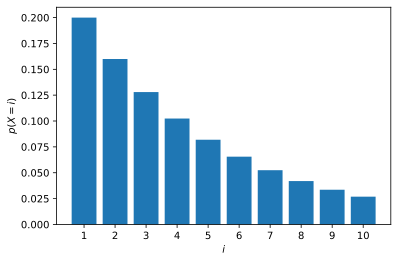

In [37]:
phi = 0.2
x = np.arange(1,11)
y = (1-phi)**(x-1)*phi
f,ax = plt.subplots()
ax.bar(x,y)
ax.set_xticks(range(1,11))
ax.set_xlabel("$i$")
ax.set_ylabel("$p(X=i)$")

Finally, note that from here on (including for the geometric distribution), we cannot use our Factor class, because it relies on explicitly enumerating all the values that a random variable can take on via the dictionary keys.  For distributions that take on an infinite number of values, we cannot enumerate all these possibilites, and so we will instead just need to functionally describe the probabilities.  Also note that this fact can sometimes make it difficult to exactly compute conditional probabilities or similar terms, as they can involve infinite sums that may not have a simple closed form.

### Poisson distribution
The Poisson distribution is distribution over the non-negative integer $0,1,2,\ldots$, and is commonly used to model, for example, the number of times an event occurs within some window of time (for example, the number of buses that arrive during a particular time frame).  It is parameterized by $\lambda \in \mathbb{R}^+$m, and  it's probability function is given by
\begin{equation}
p(X=i;\lambda) = \frac{\lambda^k e^-\lambda}{i!}.
\end{equation}
The distribution has mean and variance both
\begin{equation}
\mathbf{E}[X] = \lambda, \;\; \mathbf{Var}[X] = \lambda.
\end{equation}

The probability looks like the following for $\lambda=3$.

In [38]:
# poisson
lam = 3
x = np.arange(0,10)
y = (lam**x*np.exp(-lam)/misc.factorial(x))
f,ax = plt.subplots()
ax.bar(x,y)
ax.set_xticks(range(0,10))
ax.set_xlabel("$i$")
ax.set_ylabel("$p(X=i)$")

AttributeError: module 'scipy.misc' has no attribute 'factorial'

### Gaussian distribution

The Gaussian distribution is a distribution over real-valued numbers, and is probably the most common distribution in data science (not I'm _not_ saying that it is the most common distribution in the _data_ itself, but in data science as a field).  This is due to many nice properties of the distribution it is easy to integrate, and has a natural multivariate analogue, and also due to the fact's that we'll talk about in a few lectures, that certain data distributions of sample means tend towards Gaussian distribution (the so-called central limit theorem).  The Gaussian has the "bell-shaped" density function that is probably familiar to many people.

Text(0, 0.5, '$p(x)$')

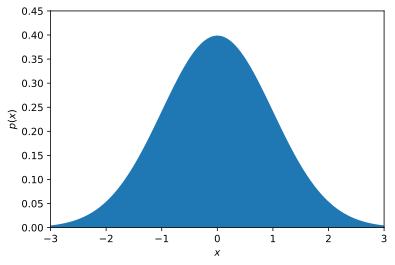

In [39]:
# poisson
mu = 0
sig2 = 1.0
x = np.linspace(-3,3,101)
y = 1/np.sqrt(2*np.pi*sig2)*np.exp(-x**2/(2*sig2))

f,ax = plt.subplots()
ax.fill_between(x,y,np.zeros_like(y))
ax.set_xlim(-3,3)
ax.set_ylim(0,0.45)
ax.set_xlabel("$x$")
ax.set_ylabel("$p(x)$")

The one-dimesional Gaussian distribution is typically parameterized by two parameters $\mu \in \mathbb{R}$ (the mean), and $\sigma^2 \in \mathbb{R}_+$ (the variance).  It's not important whether we technically parameterize by the variance or in the standard deviation (square root of the variance), so we'll use the variance as our parameter, since this matches better with the multivariate funciton.  The probability density function of the Gaussian is given by
\begin{equation}
p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{\|x - \mu\|_2^2}{2\sigma^2} \right)
\end{equation}